Name: Vaishnvi Sanket Chitari
Homework: 4

In [1]:
using Pkg
Pkg.add(["Lux", "Flux", "MLUtils", "Plots", "Statistics", "Zygote", "Random", "CUDA", "MLDatasets"])


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed ContextVariablesX ────── v0.1.3
   Installed ZygoteRules ──────────── v0.2.7
   Installed ZipFile ──────────────── v0.10.1
   Installed InitialValues ────────── v0.3.1
   Installed Accessors ────────────── v0.1.42
   Installed MAT ──────────────────── v0.10.7
   Installed ShowCases ────────────── v0.1.0
   Installed PrettyPrint ──────────── v0.2.0
   Installed RealDot ──────────────── v0.1.0
   Installed GZip ─────────────────── v0.6.2
   Installed JLD2 ─────────────────── v0.5.15
   Installed Hwloc_jll ────────────── v2.12.1+0
   Installed MLUtils ──────────────── v0.4.8
   Installed FLoopsBase ───────────── v0.1.1
   Installed MLCore ───────────────── v1.0.0
   Installed ProgressLogging ──────── v0.1.5
   Installed IRTools ──────────────── v0.4.15
   Installed Chemfiles ────────────── v0.10.42
   Installed MicrosoftMPI_jll ─────── v10.1.4+3
   Installed DefineSingletons ─────── v

In [2]:
import Pkg; Pkg.add("Functors")
import Pkg; Pkg.add("OneHotArrays")
import Pkg; Pkg.add("Optimisers")

   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [d9f16b24] + Functors v0.5.2
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [0b1bfda6] + OneHotArrays v0.2.10
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [3bd65402] + Optimisers v0.4.6
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


1. Implement a one hidden layer MLP, and vary the size of the hidden layer (10, 20, 40, 50, 100,
300) and train for 10 Epochs on FashionMNIST and store the final test accuracy. Then plot
the accuracy as a function of the hidden layer size.


In [11]:
using Lux, Optimisers, Zygote, MLUtils, MLDatasets, Statistics, Plots
using OneHotArrays: onehotbatch, onecold
using Random
using Flux: softmax, Losses

# FashionMNIST
train_x, train_y = FashionMNIST(:train)[:]
test_x,  test_y  = FashionMNIST(:test)[:]


train_x = Float32.(reshape(train_x, 28, 28, 1, :)) ./ 255
test_x = Float32.(reshape(test_x, 28, 28, 1, :)) ./ 255
train_y = onehotbatch(train_y, 0:9)
test_y = onehotbatch(test_y, 0:9)

# MLP model
function create_mlp(hidden_size)
    Chain(
        FlattenLayer(),
        Dense(28*28, hidden_size, relu),
        Dense(hidden_size, 10),
    )
end

# Training function
function train_model(model, ps, st, data, testdata; epochs=10, η=0.01)
    opt = Optimisers.Adam(η)
    st_opt = Optimisers.setup(opt, ps)

    for epoch in 1:epochs
        for (x, y) in data
            gs = gradient(ps) do p
                ŷ, _ = Lux.apply(model, x, p, st)
                Losses.logitcrossentropy(ŷ, y)
            end
            st_opt, ps = Optimisers.update(st_opt, ps, gs[1]) # gs is a tuple, gs[1] is gradient wrt ps
        end
    end

    # Evaluate test set
    test_pred = Lux.apply(model, testdata[1], ps, st)[1]
    accuracy = mean(onecold(test_pred) .== onecold(testdata[2]))
    return accuracy
end


hidden_sizes = [10, 20, 40, 50, 100, 300]
accuracies = Float64[]

for h in hidden_sizes
    model = create_mlp(h)
    rng = Random.default_rng()
    ps, st = Lux.setup(rng, model)
    acc = train_model(model, ps, st,
                     DataLoader((train_x, train_y), batchsize=32, shuffle=true),
                     (test_x, test_y))
    push!(accuracies, acc)
    println("Hidden size $h: Accuracy = $acc")
end





Hidden size 10: Accuracy = 0.7798
Hidden size 20: Accuracy = 0.84
Hidden size 40: Accuracy = 0.857
Hidden size 50: Accuracy = 0.8442
Hidden size 100: Accuracy = 0.8535
Hidden size 300: Accuracy = 0.8566


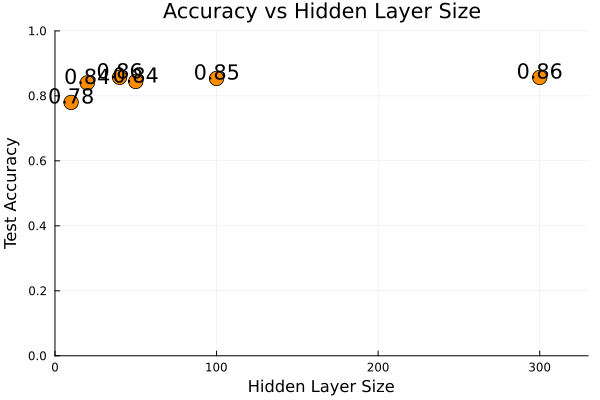

In [12]:
using Plots
using Printf

scatter(hidden_sizes, accuracies,
    xlabel = "Hidden Layer Size",
    ylabel = "Test Accuracy",
    title = "Accuracy vs Hidden Layer Size",
    marker = (:circle, 8),
    color = :darkorange,
    legend = false,
    xlims = (0, maximum(hidden_sizes)*1.1),
    ylims = (0, 1),
    grid = true)

# Add accuracy labels near each point
annotate!([(h, a + 0.02, @sprintf("%.2f", a)) for (h, a) in zip(hidden_sizes, accuracies)])


2. Use the same network with fixed hidden layer size of 30 to estimate the impact of random initialisation. Run the network 10 times with different weight initialisation. Compute standard
deviation and mean. Visualize the datapoints in a plot to make the fluctuations of the final
test accuracy visible.


Mean accuracy: 
σ


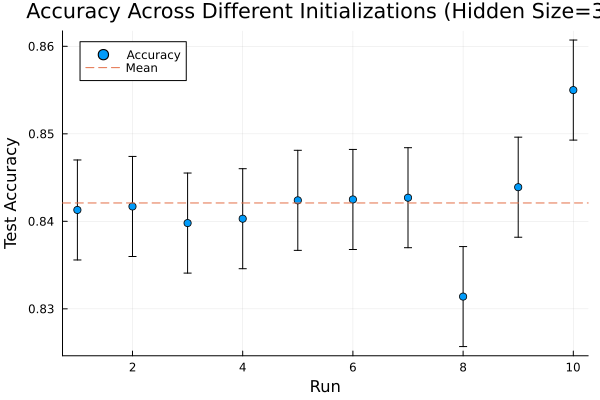

In [13]:
n_runs = 10
accuracies_30 = Float64[]

for _ in 1:n_runs
    rng = Random.default_rng()
    model = create_mlp(30)
    ps, st = Lux.setup(rng, model)
    acc = train_model(model, ps, st,
                     DataLoader((train_x, train_y), batchsize=32, shuffle=true),
                     (test_x, test_y))
    push!(accuracies_30, acc)
end

μ = mean(accuracies_30)
σ = std(accuracies_30)

println("Mean accuracy:
σ")

scatter(1:n_runs, accuracies_30, yerr=σ, xlabel="Run", ylabel="Test Accuracy",
        title="Accuracy Across Different Initializations (Hidden Size=30)",
        label="Accuracy")
hline!([μ], label="Mean", linestyle=:dash)

3. Train the model with a batch size of 32 for 25 epochs. Use a decaying learning rate schedule
of your choice.


In [15]:
function train_with_schedule(model, ps, st, data, testdata; epochs=25, batchsize=32)
    # decay learning rate schedule
    schedule(epoch) = 0.01 * exp(-0.1 * epoch)


    function loss(x, y, ps, st)
        y_pred, st = Lux.apply(model, x, ps, st)
        logits = softmax(y_pred)
        return -sum(y .* log.(logits)) / size(y, 2), st  # Cross-entropy loss
    end

    for epoch in 1:epochs
        η = schedule(epoch)
        opt = Optimisers.Adam(η)
        st_opt = Optimisers.setup(opt, ps)

        for (x, y) in DataLoader(data, batchsize=batchsize, shuffle=true)
            (l, st), back = Zygote.pullback(p -> loss(x, y, p, st), ps)
            gs = back((1.0f0, nothing))[1]  # Get gradients only for parameters
            st_opt, ps = Optimisers.update(st_opt, ps, gs)
        end


        if epoch % 5 == 0
            test_pred, _ = Lux.apply(model, testdata[1], ps, st)
            acc = mean(onecold(test_pred) .== onecold(testdata[2]))
            println("Epoch $epoch: Test accuracy = $acc")
        end
    end


    test_pred, _ = Lux.apply(model, testdata[1], ps, st)
    accuracy = mean(onecold(test_pred) .== onecold(testdata[2]))
    return accuracy
end

# Create and train the model
model = create_mlp(100)
rng = Random.default_rng()
ps, st = Lux.setup(rng, model)
acc = train_with_schedule(model, ps, st, (train_x, train_y), (test_x, test_y))
println("Final test accuracy: $acc")

Epoch 5: Test accuracy = 0.84
Epoch 10: Test accuracy = 0.859
Epoch 15: Test accuracy = 0.8636
Epoch 20: Test accuracy = 0.8673
Epoch 25: Test accuracy = 0.8682
Final test accuracy: 0.8682


4. Optimise the batch size and the learning rate schedule via a small grid search.


In [16]:
batch_sizes = [16, 32, 64, 128]
lr_schedules = [
    (epoch -> 0.1 * exp(-0.1 * epoch), "Exp Decay 0.1"),
    (epoch -> 0.01 * exp(-0.05 * epoch), "Exp Decay 0.01"),
    (epoch -> 0.001 * (1 + cos(π * epoch / 25)), "Cosine"),
]

best_acc = 0.0
best_params = (bs=0, schedule=nothing)

for bs in batch_sizes
    for (schedule, desc) in lr_schedules
        model = create_mlp(100)
        ps, st = Lux.setup(rng, model)

        function custom_train(model, ps, st, data, testdata; epochs=25)
            for epoch in 1:epochs
                η = schedule(epoch)
                opt = Optimisers.Adam(η)
                st_opt = Optimisers.setup(opt, ps)

                function loss(x, y, ps, st)
                    y_pred, st = Lux.apply(model, x, ps, st)
                    logits = softmax(y_pred)
                    return -sum(y .* log.(logits)) / size(y, 2), st
                end

                for (x, y) in DataLoader(data, batchsize=bs, shuffle=true)
                    (l, st), back = Zygote.pullback(p -> loss(x, y, p, st), ps)
                    gs = back((1.0f0, nothing))[1]
                    st_opt, ps = Optimisers.update(st_opt, ps, gs)
                end
            end

            test_pred, _ = Lux.apply(model, testdata[1], ps, st)
            mean(onecold(test_pred) .== onecold(testdata[2]))
        end

        acc = custom_train(model, ps, st, (train_x, train_y), (test_x, test_y))
        println("Batch $bs, $desc: Accuracy = $acc")

        if acc > best_acc
            best_acc = acc
            best_params = (bs=bs, schedule=desc)
        end
    end
end

println("Best params: Batch $(best_params.bs), $(best_params.schedule) with accuracy $best_acc")

Batch 16, Exp Decay 0.1: Accuracy = 0.1
Batch 16, Exp Decay 0.01: Accuracy = 0.1
Batch 16, Cosine: Accuracy = 0.8609
Batch 32, Exp Decay 0.1: Accuracy = 0.1
Batch 32, Exp Decay 0.01: Accuracy = 0.878
Batch 32, Cosine: Accuracy = 0.8495
Batch 64, Exp Decay 0.1: Accuracy = 0.1
Batch 64, Exp Decay 0.01: Accuracy = 0.8753
Batch 64, Cosine: Accuracy = 0.8407
Batch 128, Exp Decay 0.1: Accuracy = 0.1
Batch 128, Exp Decay 0.01: Accuracy = 0.8673
Batch 128, Cosine: Accuracy = 0.8305
Best params: Batch 32, Exp Decay 0.01 with accuracy 0.878


5. Use the parameters which yield the best and train the network.


In [18]:
function create_optimized_trainer(bs, schedule)
    function trainer(model, ps, st, data, testdata; epochs=25)
        for epoch in 1:epochs
            η = schedule(epoch)
            opt = Optimisers.Adam(η)
            st_opt = Optimisers.setup(opt, ps)

            function loss(x, y, ps, st)
                y_pred, st = Lux.apply(model, x, ps, st)
                logits = softmax(y_pred)
                return -sum(y .* log.(logits)) / size(y, 2), st
            end

            for (x, y) in DataLoader(data, batchsize=bs, shuffle=true)
                (l, st), back = Zygote.pullback(p -> loss(x, y, p, st), ps)
                gs = back((1.0f0, nothing))[1]
                st_opt, ps = Optimisers.update(st_opt, ps, gs)
            end
        end

        test_pred, _ = Lux.apply(model, testdata[1], ps, st)
        mean(onecold(test_pred) .== onecold(testdata[2]))
    end
    return trainer
end

create_optimized_trainer (generic function with 1 method)

In [19]:
best_schedule = epoch -> 0.01 * exp(-0.05 * epoch)
best_bs = 64  # Example best batch size

optimized_train = create_optimized_trainer(best_bs, best_schedule)
model = create_mlp(100)
ps, st = Lux.setup(rng, model)
final_acc = optimized_train(model, ps, st, (train_x, train_y), (test_x, test_y))
println("Final optimized accuracy: $final_acc")

Final optimized accuracy: 0.8768


 Did you improve your result
in 3?

yes I did. Before it was 0.8682 and now it is 0.8768
